In [1]:
# !pip3 install sentence_transformers
# !pip3 install torchview
# !pip install torchsummary
# !brew install graphviz
# !pip install torchviz
%load_ext autotime

import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, losses
import pandas as pd
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
# from torchview import draw_graph
# from torchsummary import summary
pd.set_option("max_colwidth", None)

from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training, TaskType, PeftModel # peft-0.7.1
from transformers import (
    AutoModel,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    AutoConfig,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

time: 6.42 s (started: 2024-03-22 11:32:16 +00:00)


In [2]:
model_name = 'sentence-transformers/all-mpnet-base-v2'

# Define your custom stance-aware loss function
class SiameseNetworkMPNet(nn.Module):
    def __init__(self, model_name, tokenizer, normalize=True):
        super(SiameseNetworkMPNet, self).__init__()

        self.model = AutoModel.from_pretrained(model_name)#, quantization_config=bnb_config, trust_remote_code=True)
        self.normalize = normalize
        self.tokenizer = tokenizer

    def forward(self, **inputs):
        model_output = self.model(**inputs)
        attention_mask = inputs['attention_mask']
        last_hidden_states = model_output.last_hidden_state  # First element of model_output contains all token embeddings
        embeddings = torch.sum(last_hidden_states * attention_mask.unsqueeze(-1), 1) / torch.clamp(attention_mask.sum(1, keepdim=True), min=1e-9) # mean_pooling
        if self.normalize:
            embeddings = F.layer_norm(embeddings, embeddings.shape[1:])
            embeddings = F.normalize(embeddings, p=2, dim=1)

        return embeddings



# Custom dataset for your DataFrame
class CustomDataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]


def batch_and_encode(df_sentences_col,finetuned_model_x,is_lora):
    models_dir = 'Models/'
    
    torch.cuda.empty_cache()
    # Load the pre-trained "all-mpnet-base-v2" model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Initialize the model
    model = SiameseNetworkMPNet(model_name=model_name, tokenizer=tokenizer)

    if finetuned_model_x != 'original':
        if is_lora == False:
            model.load_state_dict(torch.load('Models/'+finetuned_model_x+'.pt'))
        if is_lora == True:
            model.apply_lora_weights("vahidthegreat/StanceAware-SBERT")

    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Assuming you have a DataFrame named df with columns "sentence_i" and "sentence_j"
    dataset_i = CustomDataset(df_sentences_col.tolist())

    # Use DataLoader for batch processing
    batch_size = 32
    dataloader_i = DataLoader(dataset_i, batch_size=batch_size, shuffle=False)

    # Lists to store the embeddings for "sentence_i" and "sentence_j"
    embeddings_i_list = []


    # Encode sentences in batches
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for sentences_i_batch in tqdm(dataloader_i):
            text1 = tokenizer(sentences_i_batch, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
            embeddings_i = model(**text1.to(device)).tolist()
            embeddings_i = [[round(value, 4) for value in row] for row in embeddings_i]
#             embeddings_i = encode_sentences(sentences_i_batch).tolist()
            embeddings_i_list.extend(embeddings_i)
    return embeddings_i_list

time: 5.87 ms (started: 2024-03-22 11:32:31 +00:00)


In [3]:
meta_data=pd.read_excel('Datasets/Kialo_MetaData_all.xlsx')
sentence_pairs_df = pd.concat([pd.read_csv('Datasets/argument_pairs_branchleaf.csv'),pd.read_csv('Datasets/argument_pairs_leafleaf.csv')],ignore_index=True)
sentence_pairs_df['url'] = sentence_pairs_df['post_id'].map(dict(zip(meta_data['post_id'],meta_data['url'])))
sentence_pairs_df = sentence_pairs_df[(sentence_pairs_df['stance']=='Pro') | (sentence_pairs_df['stance']=='Con')]
sentence_pairs_df['stance_numeric'] = sentence_pairs_df['stance'].map({'Pro':1,'Con':0})
print(f"original length: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df.dropna()
print(f"length after droping nulls: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df[sentence_pairs_df['sentence_i'] != sentence_pairs_df['sentence_j']]
sentence_pairs_df['sorted_sentences'] = sentence_pairs_df.progress_apply(lambda row: tuple(sorted([row['sentence_i'], row['sentence_j']])), axis=1)
sentence_pairs_df.drop_duplicates(subset='sorted_sentences',inplace=True)
sentence_pairs_df.drop(columns=['sorted_sentences'],inplace=True)
print(f"length after dropping duplicates: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df[(sentence_pairs_df['sentence_i'].progress_apply(lambda x: len(x.split(' ')))>3) & (sentence_pairs_df['sentence_j'].progress_apply(lambda x: len(x.split(' ')))>3)]
print(f"length after removing short sentences: {len(sentence_pairs_df)}")
# Splitting into train and test sets
# sentence_pairs_df, sentence_pairs_test_df = train_test_split(sentence_pairs_df, test_size=0.1, random_state=1)
# Group the DataFrame by "post_id"
meta_data = meta_data[meta_data['language']=='en']
post_id_set = list(set(list(meta_data["post_id"])))

# Initialize empty lists for train and test indices
train_indices = []
test_indices = []


train_indices, test_indices = train_test_split(post_id_set, test_size=0.1, random_state=1)  # Adjust the test_size as needed

# Split the original DataFrame using the train and test indices
sentence_pairs_train_df = sentence_pairs_df[sentence_pairs_df["post_id"].isin(train_indices)]
sentence_pairs_test_df = sentence_pairs_df[sentence_pairs_df["post_id"].isin(test_indices)]
# sentence_pairs_test_df = sentence_pairs_test_df[sentence_pairs_test_df["cosine_similarity"]>0.5]
print(f"length of train-set: {len(sentence_pairs_train_df)}")
print(f"length of test-set: {len(sentence_pairs_test_df)}")

sentence_pairs_test_df.reset_index(drop=True,inplace=True)

# sentence_pairs_test_df = sentence_pairs_test_df.sample(n=10000,random_state=1)
# sentence_pairs_train_df = sentence_pairs_train_df.sample(n=10000,random_state=1)

original length: 1134249
length after droping nulls: 1134249


  0%|          | 0/1133848 [00:00<?, ?it/s]

length after dropping duplicates: 1108680


  0%|          | 0/1108680 [00:00<?, ?it/s]

  0%|          | 0/1108680 [00:00<?, ?it/s]

length after removing short sentences: 1085119
length of train-set: 972395
length of test-set: 112724
time: 46.5 s (started: 2024-03-22 11:32:37 +00:00)


In [10]:
len(sentence_triplets_test_df)

34453

time: 3.09 ms (started: 2024-02-28 10:58:10 +00:00)


0.0042304550277109535


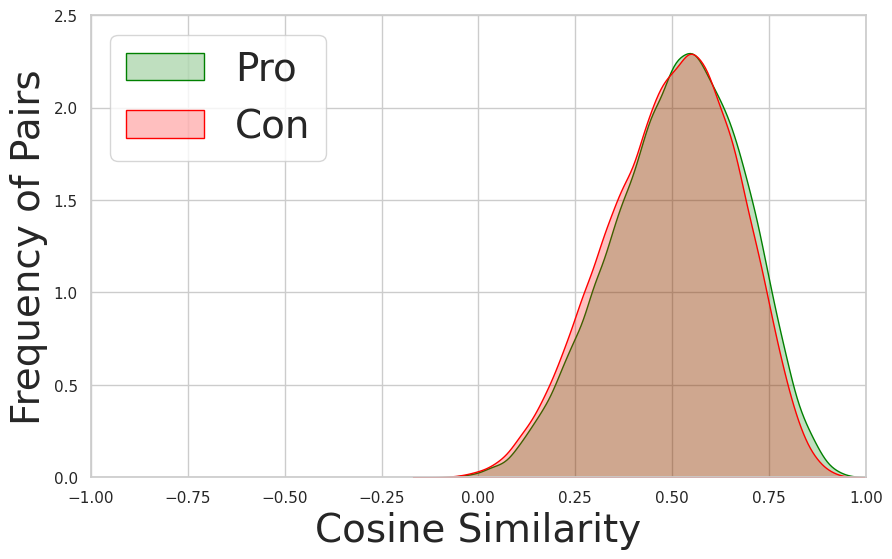

time: 2.09 s (started: 2024-03-22 11:34:02 +00:00)


In [4]:
from scipy.stats import entropy

finetuned_model_i = 'original'

# sentence_pairs_test_df[f'embeddings_i_{finetuned_model_i}'] = batch_and_encode(df_sentences_col=sentence_pairs_test_df['sentence_i'],finetuned_model_x = finetuned_model_i,is_lora=False)
# sentence_pairs_test_df[f'embeddings_j_{finetuned_model_i}'] = batch_and_encode(df_sentences_col=sentence_pairs_test_df['sentence_j'],finetuned_model_x = finetuned_model_i,is_lora=False)
# sentence_pairs_test_df['cosine_similarity_new'] = sentence_pairs_test_df.progress_apply(lambda row: 1 - cosine(row[f'embeddings_i_{finetuned_model_i}'], row[f'embeddings_j_{finetuned_model_i}']), axis=1)
# sentence_pairs_test_df = sentence_pairs_test_df[sentence_pairs_test_df['relationship']=="branch-leaf"]
# Set up Seaborn settings
sns.set(style="whitegrid")

# Extract cosine similarities for "Pro" and "Con" stances
cosine_similarity_pro = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Pro']#['cosine_similarity_new']
cosine_similarity_con = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Con']#['cosine_similarity_new']

# Calculate the histograms of cosine similarities
hist_pro, bin_edges_pro = np.histogram(cosine_similarity_pro['cosine_similarity'], bins=50, density=True)
hist_con, bin_edges_con = np.histogram(cosine_similarity_con['cosine_similarity'], bins=50, density=True)

# Calculate the probability distributions
pdf_pro = hist_pro / np.sum(hist_pro)
pdf_con = hist_con / np.sum(hist_con)

# Calculate KL Divergence
kl_divergence = entropy(pdf_pro, pdf_con)
print(kl_divergence)

# Create density plots for each stance
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cosine_similarity_pro, x='cosine_similarity', label='Pro', fill=True,color='green')
sns.kdeplot(data=cosine_similarity_con, x='cosine_similarity', label='Con', fill=True,color='red')

# Add labels and title
plt.xlabel('Cosine Similarity', fontsize=28)
plt.ylabel('Frequency of Pairs', fontsize=28)
# plt.title(f'Cosine Similarities PDF - Test Set - Model: {finetuned_model_i}')
plt.xlim([-1,1])
plt.ylim([0,2.5])
# Show legend
plt.legend(loc='upper left',fontsize=28)

plt.savefig(f'Plots/testset_original.png', dpi=300, bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/1897 [00:00<?, ?it/s]

  0%|          | 0/1897 [00:00<?, ?it/s]

  0%|          | 0/60673 [00:00<?, ?it/s]

model name: vahidthegreat/StanceAware-SBERT
0.4387258129444429


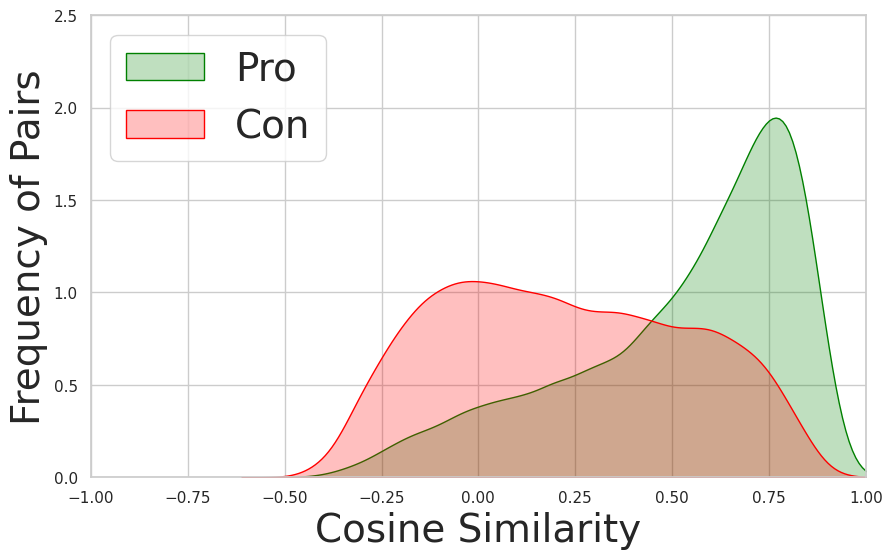

time: 5min 52s (started: 2024-03-22 11:35:22 +00:00)


In [6]:
from scipy.stats import entropy
# siamese_type = 'contrastive'
# siamese_type = 'triplet'
siamese_type = 'contriplet'
epoch = 4
# is_lora = False
is_lora = True

sentence_pairs_test_df = sentence_pairs_test_df[sentence_pairs_test_df["cosine_similarity"]>0.5]
if is_lora == True:
    lora = 'LoRA'
if is_lora == False:
    lora = 'Full'    

# removal = 30
removal = 50
# removal = 0

# for margin_i in [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
for margin_i in [0.4]:

    
    margin_i = int(margin_i*100)

    finetuned_model_i = f'vahidthegreat/StanceAware-SBERT'

    sentence_pairs_test_df[f'embeddings_i_{finetuned_model_i}'] = batch_and_encode(df_sentences_col=sentence_pairs_test_df['sentence_i'],finetuned_model_x = finetuned_model_i,is_lora=is_lora)
    sentence_pairs_test_df[f'embeddings_j_{finetuned_model_i}'] = batch_and_encode(df_sentences_col=sentence_pairs_test_df['sentence_j'],finetuned_model_x = finetuned_model_i,is_lora=is_lora)

    # Calculate cosine similarities between embeddings_i_original and embeddings_j_original
    sentence_pairs_test_df['cosine_similarity_new_'] = sentence_pairs_test_df.progress_apply(lambda row: 1 - cosine(row[f'embeddings_i_{finetuned_model_i}'], row[f'embeddings_j_{finetuned_model_i}']), axis=1)
#     sentence_pairs_test_df = sentence_pairs_test_df[sentence_pairs_test_df['relationship']=="branch-leaf"]
    # Set up Seaborn settings
    sns.set(style="whitegrid")
    
    # Extract cosine similarities for "Pro" and "Con" stances
    cosine_similarity_pro = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Pro']#['cosine_similarity_new']
    cosine_similarity_con = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Con']#['cosine_similarity_new']

    # Calculate the histograms of cosine similarities
    hist_pro, bin_edges_pro = np.histogram(cosine_similarity_pro['cosine_similarity_new_'], bins=50, density=True)
    hist_con, bin_edges_con = np.histogram(cosine_similarity_con['cosine_similarity_new_'], bins=50, density=True)
    
    epsilon = 1e-10

    # Calculate the probability distributions
    pdf_pro = hist_pro / np.sum(hist_pro) + epsilon
    pdf_con = hist_con / np.sum(hist_con) + epsilon

    # Calculate KL Divergence
    print(f'model name: {finetuned_model_i}')
    kl_divergence = entropy(pdf_pro, pdf_con)
    print(kl_divergence)

    # Create density plots for each stance
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=cosine_similarity_pro, x='cosine_similarity_new_', label='Pro', fill=True,color='green')
    sns.kdeplot(data=cosine_similarity_con, x='cosine_similarity_new_', label='Con', fill=True,color='red')

    # Add labels and title
    plt.xlabel('Cosine Similarity', fontsize=28)
    plt.ylabel('Frequency of Pairs', fontsize=28)
#     plt.title(f'Cosine Similarities PDF - Test Set - Model: {finetuned_model_i}')
    plt.xlim([-1,1])
    plt.ylim([0,2.5])
    # Show legend
    plt.legend(loc='upper left',fontsize=28)

    # Save the plot
    plt.savefig(f'Plots/testset_{finetuned_model_i}_{lora}.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()